ROOTとNOUN(PRON)を見つけて繋ぐだけ

In [1]:
import spacy
from spacy import displacy
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Cup, Id, Ty, Word

n, s = Ty('n'), Ty('s')
# nlp = spacy.load("ja_core_web_sm")
nlp = spacy.load("en_core_web_trf")
# nlp = spacy.load("en_core_web_trf")
# モデルの大きさによって解析精度に差あり

c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\transformers\utils\generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\transformers\utils\generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\thinc\shims\pytorch.py:261: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the

In [2]:
sentence = 'skillful man prepares sauce .'
doc = nlp(sentence)
displacy.serve(doc, style='dep', port=5001)

for token in doc:
    print(token.text+'<-'+token.head.text,token.dep_)

# 文頭を大文字、文末にピリオド をちゃんとやると正確になりやすいかも

c:\Users\neoia\anaconda3\envs\lambeq_env2\Lib\site-packages\spacy\displacy\__init__.py:106: UserWarning: [W011] It looks like you're calling displacy.serve from within a Jupyter notebook or a similar environment. This likely means you're already running a local web server, so there's no need to make displaCy start another one. Instead, you should be able to replace displacy.serve with displacy.render to show the visualization.
  warnings.warn(Warnings.W011)



Using the 'dep' visualizer
Serving on http://0.0.0.0:5001 ...

Shutting down server on port 5001.
skillful<-man amod
man<-prepares nsubj
prepares<-prepares ROOT
sauce<-prepares dobj
.<-prepares punct


In [3]:
# 型の割り当て
def assign_types(doc):
    pregroup_types = {}
    doc = nlp(sentence)
    # トークン化
    tokens = [token.text for token in doc]
    # 依存関係をまとめる
    # dependencies = [(token.text, token.head.text) for token in doc if token.text != "."]
    dependencies = []
    
    for token in doc:
        if token.dep_ == 'ROOT':
            pregroup_types[token.text] = s
            dependencies.append((token.text, token.head.text))
        elif token.pos_ in ['NOUN','PRON']:
            pregroup_types[token.text] = n
            if token.head.dep_ == 'ROOT':
                dependencies.append((token.text, token.head.text))
    print(dependencies)
    # 依存関係による型の割り当て（ペアと語順）
    for token in doc:
        for dep in dependencies:
            if token.text == dep[1]:
                idx1 = tokens.index(dep[0])
                idx2 = tokens.index(dep[1])
                if pregroup_types[dep[0]] == n:
                    if idx1 < idx2:
                        pregroup_types[token.text] = n.r @ pregroup_types[token.text]
                    else:
                        pregroup_types[token.text] = pregroup_types[token.text] @ n.l
                # elif pregroup_types[dep[0]] == s:
                    # if idx1 < idx2:
                        # pregroup_types[token.text] = s.r @ pregroup_types[token.text]
                    # else:
                        # pregroup_types[token.text] = pregroup_types[token.text] @ s.l

    return pregroup_types

In [4]:
# diagram作成
def create_diagram(sentence):
    doc = nlp(sentence)
    pregroup_types = assign_types(doc)

    words = []
    types = Ty()

    # 初めの形を作る
    for word, type in pregroup_types.items():
        words.append(Word(word, type))

    diagram = Id().tensor(*words)

    for type in pregroup_types.values():
        types @= type
    
    # カップ構造を作る
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:  
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s @ s.r:
            diagram = diagram >> types[:i] @ Cup(s, s.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == s.l @ s:
            diagram = diagram >> types[:i] @ Cup(s.l, s) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1
            
    return diagram

[('man', 'cooks'), ('cooks', 'cooks'), ('meal', 'cooks')]
Skillful man cooks meal.


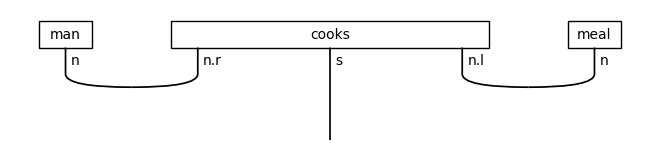

In [32]:
sentence = 'Skillful man cooks meal.'
diagram = create_diagram(sentence)
print(sentence)
draw(diagram)

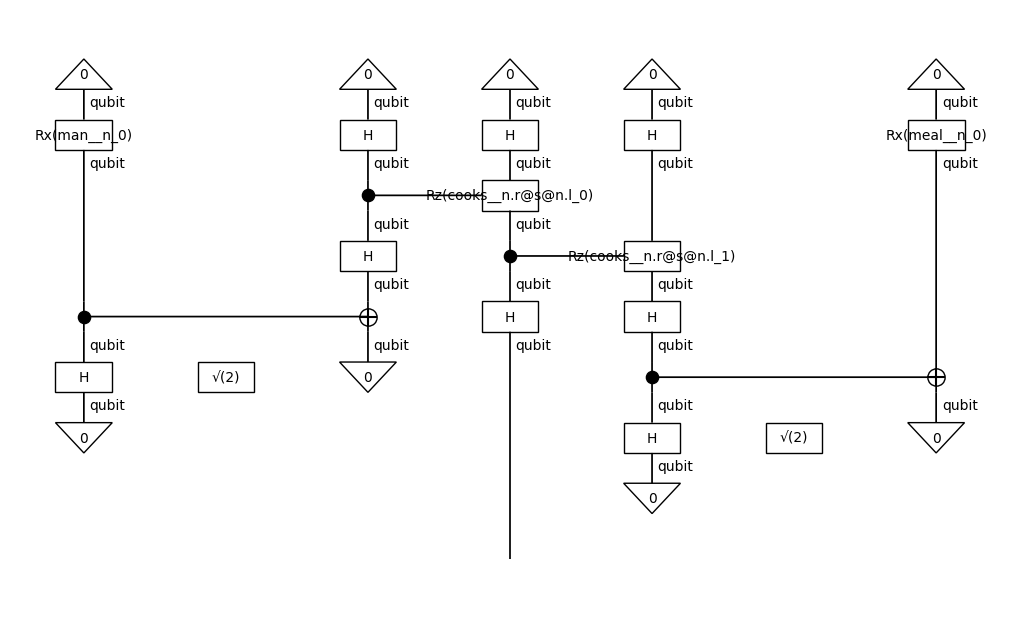

In [33]:
from lambeq import IQPAnsatz, AtomicType
# 量子回路設計（IQPAnsatz）
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=1)
circuits = ansatz(diagram)


circuits.draw(figsize=(10, 6))